# 对时光网影史Top100排行榜进行数据分析    
    本篇分析目的主要是通过对时光网Top100电影的数据分析Top100电影的评分范围为多少，以及得出哪些年代，类型的电影是最热门的或票房最高的。
    
**Ref:**

[时光网影史Top100排行榜](http://movie.mtime.com/boxoffice/#world/all)

[python 爬取时光网电影票房数据](https://blog.csdn.net/weixin_39416561/article/details/86504061)

## 主要数据获取
利用python爬取时光网http://movie.mtime.com/boxoffice/#world/all 的影史票房Top100的数据，其中包括电影名称，评分，类型，上映日期，票房总数等数据。首先使用requests对网站进行访问，然后使用BeautifulSoup对网站进行解析，获取所需的数据，并导出到excel文件中。爬虫文件具体看`shiguangTOP100.py`文件。

In [1]:
# 导入各种包
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import datetime

In [2]:
# 查看通过爬虫出来的原数据集
df_raw = pd.read_excel('raw_data.xlsx')  # 查看爬取下来的数据集
df_raw.head()

,排名,电影,评分,类型,年度票房（美元）,上映日期
0,1,复仇者联盟4：终局之战,8.2,动作/冒险,27.98亿,2019年04月26日
1,2,阿凡达,8.8,动作/冒险,27.90亿,2009年12月17日
2,3,泰坦尼克号,8.9,剧情/爱情,21.88亿,1997年12月19日
3,4,星球大战：原力觉醒,7.6,动作/冒险,20.68亿,2015年12月18日
4,5,复仇者联盟3：无限战争,8.1,动作/冒险,20.48亿,2018年04月27日


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   排名        100 non-null    int64  
 1   电影        100 non-null    object 
 2   评分        100 non-null    float64
 3   类型        100 non-null    object 
 4   年度票房（美元）  100 non-null    object 
 5   上映日期      100 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 4.8+ KB


In [4]:
df_raw.describe()

,排名,评分
count,100.000000,100.000000
mean,50.500000,7.828000
std,29.011492,0.521474
min,1.000000,6.800000
25%,25.750000,7.400000
50%,50.500000,7.800000
75%,75.250000,8.200000
max,100.000000,9.100000


通过数据预览发现该数据集`年度票房（美元）`和`上映日期`格式都不是我们想要的，`排名`我们暂时不需要。接下来开始进行数据预处理。

In [5]:
# 数据预处理
df = df_raw

del df['排名']  # 删掉排名这一列

# 将年度票房改为亿美元，数据格式为浮点格式
def tranTickNum(s):
    s = re.sub(r'亿','', s)
    s = round(float(s), 2)
    return s
df['年度票房（亿美元）'] = df['年度票房（美元）'].apply(tranTickNum)
del df['年度票房（美元）']  # 删掉旧数据

# 将上映日期改为日期格式
def tran2date(s):
    s = re.sub(r'年', '/', s)
    s = re.sub(r'月', '/', s)
    s = re.sub(r'日','', s)
    return s
df['上映日期'] = df['上映日期'].apply(tran2date)
df['上映日期'] = pd.to_datetime(df['上映日期'],format='%Y/%m/%d', errors = 'coerce')

In [6]:
# 增添年代
df['上映年份'] = df['上映日期'].map(lambda x: x.year)
df.loc[(df['上映年份']>=1970),'年代'] = '1970-79'
df.loc[(df['上映年份']>=1980),'年代'] = '1980-89'
df.loc[(df['上映年份']>=1990),'年代'] = '1990-99'
df.loc[(df['上映年份']>=2000),'年代'] = '2000-09'
df.loc[(df['上映年份']>=2010),'年代'] = '2010-20'
del df['上映年份']

In [7]:
# 查看处理后的数据
df.head()

,电影,评分,类型,上映日期,年度票房（亿美元）,年代
0,复仇者联盟4：终局之战,8.2,动作/冒险,2019-04-26,27.98,2010-20
1,阿凡达,8.8,动作/冒险,2009-12-17,27.90,2000-09
2,泰坦尼克号,8.9,剧情/爱情,1997-12-19,21.88,1990-99
3,星球大战：原力觉醒,7.6,动作/冒险,2015-12-18,20.68,2010-20
4,复仇者联盟3：无限战争,8.1,动作/冒险,2018-04-27,20.48,2010-20


经过一些数据处理后到数据预览可以看出，数据集有电影名称，评分，类型，上映日期，票房和年代这几种数据。

In [8]:
df.describe()

,评分,年度票房（亿美元）
count,100.000000,100.000000
mean,7.828000,10.594800
std,0.521474,3.714297
min,6.800000,7.580000
25%,7.400000,8.457500
50%,7.800000,9.595000
75%,8.200000,11.210000
max,9.100000,27.980000


通过数据描述可以看出，时光网Top100的电影中，平均分为7.8分（满分为10），最高分为9.1，最低分为6.8，说明观众对Top100的电影都有较好的评价。在年度票房数据中，最大值为27.98亿美元，最小值为7.58亿美元，平均值为10.59亿美元，最大值和最小值的跨度较大。

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   电影         100 non-null    object        
 1   评分         100 non-null    float64       
 2   类型         100 non-null    object        
 3   上映日期       100 non-null    datetime64[ns]
 4   年度票房（亿美元）  100 non-null    float64       
 5   年代         100 non-null    object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 4.8+ KB


## 数据可视化

### Top100电影评分分析

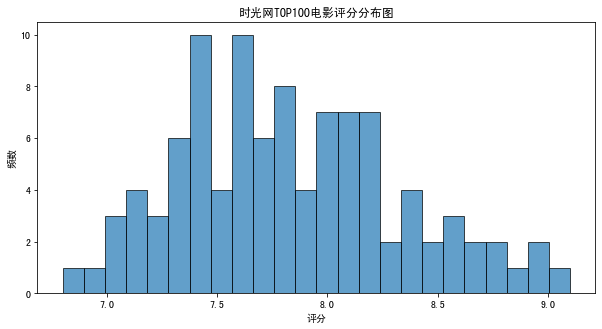

In [10]:
# 评分分布图
plt.figure(figsize=(10,5))
plt.hist(df['评分'],edgecolor='black', alpha=0.7, bins=24)
plt.title("时光网TOP100电影评分分布图")
plt.ylabel('频数')
plt.xlabel('评分')
plt.show()

通过对时光网Top100电影的评分数据进行分析得出以上分布图可知，排名前100的电影的评分都落在6.8到9.1之间，其中主要集中在7.3到8.3分中，再次说明观众对Top100的电影都有较好的评价，但是很少8.5分以上的高分。

### 不同类型的电影分析

In [11]:
df.groupby('类型')['年度票房（亿美元）'].sum()

类型
传记/剧情      9.04
冒险/剧情     60.57
冒险/奇幻     19.14
冒险/家庭    102.96
冒险/科幻     10.30
剧情/爱情     21.88
动作/冒险    554.40
动作/惊悚     10.85
动作/战争      8.70
动作/犯罪     30.30
动作/科幻      8.56
动画/冒险    162.96
动画/动作     31.67
家庭/奇幻     12.64
家庭/科幻      7.93
悬疑/惊悚      7.58
Name: 年度票房（亿美元）, dtype: float64

In [12]:
# 传记，剧情，冒险，奇幻，家庭，科幻，爱情，惊悚，战争，犯罪，悬疑
x = ['传记','剧情','冒险','奇幻','家庭','科幻','爱情','惊悚','战争','犯罪','悬疑']

In [13]:
# 各类型电影占比
y1 = []
for i in x:
    y1.append(df.loc[df['类型'].str.contains(i)]['电影'].count())
print(y1)

[1, 8, 86, 3, 13, 3, 1, 2, 1, 3, 1]


In [14]:
# 小于3部的合并为其他
x_pie=['其他']
y_pie=[]
y_else = []
for i in x:
    k = df.loc[df['类型'].str.contains(i)]['电影'].count()
    if k >= 3:
        x_pie.append(i)
        y_pie.append(k)
    else:
        y_else.append(k)
y_pie.insert(0,sum(y_else))  

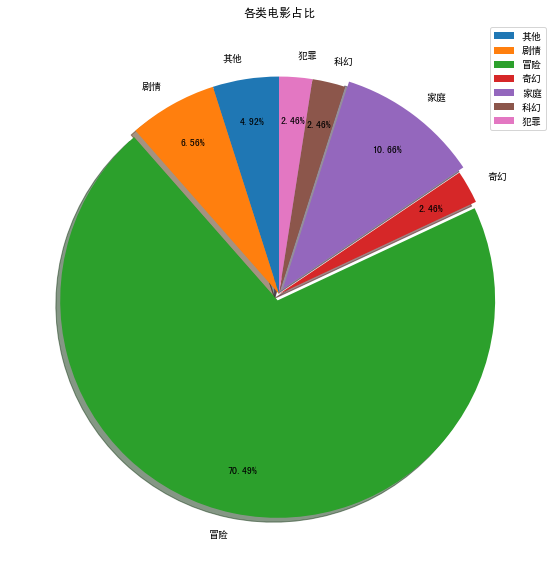

In [15]:
plt.figure(figsize=(10,10)) #调节图形大小
labels = x_pie #定义标签
sizes = y_pie #每块值
explode = (0,0,0.03,0,0.03,0,0) # 将某一块分割出来，值越大分割出的间隙越大
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      autopct = '%3.2f%%', # 数值保留固定小数位
                      shadow = True, # 阴影
                      startangle =90, # 逆时针起始角度设置
                      pctdistance = 0.8
                             )
plt.title('各类电影占比')
plt.legend()
plt.show()

由上图可以看出，该榜单中冒险类型的电影占据了70%以上，家庭类和剧情类的电影分别排在第二和第三位，占比10.66%和6.56%，这说明时光网中最受欢迎的三类电影类型为冒险，家庭和剧情。接下来对各类电影的票房进行分析。

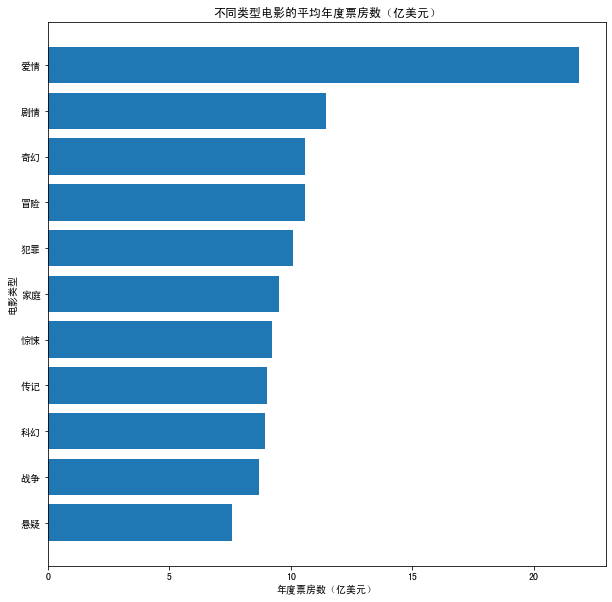

In [16]:
y2 = []
for i in x:
    y2.append(df.loc[df['类型'].str.contains(i)]['年度票房（亿美元）'].mean())
# 不同类型的电影不同的票房数
data_bar = pd.DataFrame(zip(x, y2))
data_bar = data_bar.sort_values(by=1)
plt.figure(figsize=(10,10)) #调节图形大小
plt.barh(range(len(data_bar)), data_bar[1], tick_label=data_bar[0]) 
plt.title('不同类型电影的平均年度票房数（亿美元）')
plt.ylabel('电影类型')
plt.xlabel('年度票房数（亿美元）')
plt.show()

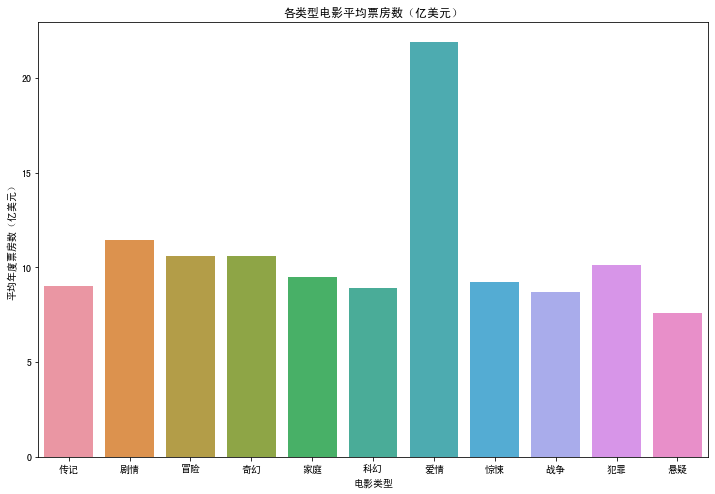

In [17]:
plt.figure(figsize=(12,8))
plt.title("各类型电影平均票房数（亿美元）")
sns.barplot(x=x, y=y2)
plt.ylabel('平均年度票房数（亿美元）')
plt.xlabel('电影类型')
plt.show()

由不同类型电影的平均年度票房数图表可知，爱情类电影的票房数接超过20亿美元，几乎是第二的剧情类电影平均票房数的两倍，而悬疑类是最低的，不足8亿美元，时光网最受欢迎的三甲类型（冒险，家庭和剧情）的票房均为10亿美元左右。这表明观众更喜欢在电影院看爱情类电影。

### 不同年代电影的分析

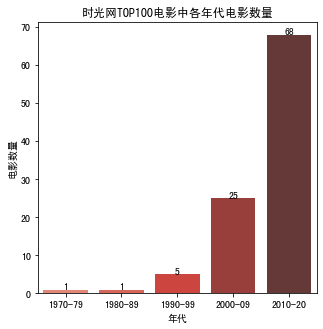

In [18]:
dftt = df.groupby('年代')['电影'].count()
rank = dftt.argsort().argsort()
pal = sns.color_palette("Reds_d",len(dftt))
plt.figure(figsize=(5,5))
g = sns.barplot(x=dftt.index,y=dftt,palette=np.array(pal[::-1])[rank])
index=np.arange(len(dftt.index))
for a,b in zip(index,dftt):
    g.text(a,b,b,color="black",ha="center")
plt.title("时光网TOP100电影中各年代电影数量")
plt.ylabel('电影数量')
plt.show()

由上图可知，时光网Top100的电影中接近70%的电影都是10-20年的电影，93%的电影都是来自于21世纪的，70年之前的电影都没能进入前100，这表明大部分观众还是喜欢看较新的电影。

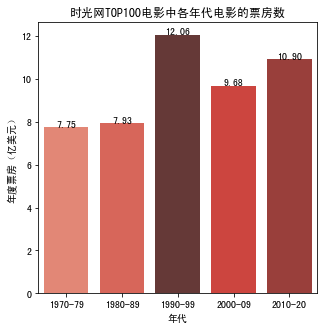

In [19]:
dft = df.groupby('年代')['年度票房（亿美元）'].mean()
rank = dft.argsort().argsort()
pal = sns.color_palette("Reds_d",len(dft))
plt.figure(figsize=(5,5))
g1 = sns.barplot(x=dft.index,y=dft,palette=np.array(pal[::-1])[rank])
index=np.arange(len(dft.index))
for a,b in zip(index,dft):
    g1.text(a,b,'%.2f'%b,color="black",ha="center")
plt.title("时光网TOP100电影中各年代电影的票房数")
plt.show()

通过对上图的观察，可以发现1980-99年的电影的平均票房是最高的，而21世纪的电影次之，这可能是观众更愿意对20世纪末的电影卖单，但除了1990-99年代外，越近年的电影平均票房越高，这可能是得益于近年电影质量的提高和科技的进步。

## 结论
	通过对时光网Top100电影排行榜的数据分析得出以下几点结论：
    
1. 用户对时光网Top100的电影都有较好的评价，但很少用户回给出8.5分以上的高分。

2. 大部分观众更喜欢看21世纪的电影，特别是2010-20年期间的电影，但是对90年代的经典电影也十分乐意在电影院观看。

3. 时光网中最受欢迎的三类电影类型分别为冒险，家庭和剧情，但是观众却更喜欢在电影院看爱情类电影。

